In [1]:
!pip install tensorflow
!pip install scikit-learn
!pip install matplotlib
!pip install prophet
!pip install yfinance
!pip install statsmodels


In [2]:
import warnings
warnings.filterwarnings ("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
#LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

Importing plotly failed. Interactive plots will not work.


In [3]:
path = ".\\"
TXN_CSV = "datasets\expense_transactions_data.csv"
MONTHLY_CSV = "datasets\monthly_category_expenses_data.csv"

In [4]:

# SETTINGS
FORECAST_MONTHS = 12     # forecast horizon (months)




LSTM_WINDOW = 6  
#how many past months to predict next month
LSTM_EPOCHS = 60
LSTM_BATCH = 16
TOP_CATEGORIES= 8 #focus on top categories for forecasting plots (reduce noise)
TEST_MONTHS = 6 #last N months kept for testing model performance
# SMALL HELPERS (few functions only)
def pick_col (df, candidates):
    """Pick the first existing column from candidates (case-insensitive)."""
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
         if cand.lower() in cols:
            return cols[cand.lower()]
    return None
   

    



def clean_amount(s):
    """Convert amounts like '1,234', '500', '$12.3' to float safely, """


    s = s.astype(str)
    s = s.str.replace(",", "", regex=False)
    s = s.str.replace("₹", "", regex=False).str.replace("$", "", regex=False)
    s = s.str.replace("INR", "", regex=False).str.replace("Rs.", "", regex=False)
    s = s.str.strip()
    return pd.to_numeric(s, errors="coerce")


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    y_true = np.array(y_true, dtype = float)
    y_pred = np.array(y_pred, dtype = float)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100


def create_lstm_sequences(arr_1d, window):
    X, y = [], []
    for i in range(len(arr_1d) - window):
        X.append(arr_1d[i:i + window])
        y.append(arr_1d[i + window])
    return np.array(X), np.array(y)





In [5]:
#-------------------------------------------------------------------------------------------------------------------------
#LOAD DATASETS
#-------------------------------------------------------------------------------------------------------------------------

txn =pd.read_csv(path + TXN_CSV)
monthly = pd.read_csv(path + MONTHLY_CSV)


txn.columns = [c.strip() for c in txn.columns]
monthly.columns = [c.strip() for c in monthly.columns]


print("Trancsaction dataset shape : ", txn.shape)
print("Monthly dataset shape : ", monthly.shape)




Trancsaction dataset shape :  (7366, 8)
Monthly dataset shape :  (1008, 5)


In [6]:
#-------------------------------------------------------------------------------------------------------------------------
# STANDARDIZE MONTHLY DATA (Date/Month, Category, Amount)
#-------------------------------------------------------------------------------------------------------------------------

# Try to detect monthly columns
month_col = pick_col(monthly, ["Month", "Date", "YearMonth", "MonthYear", "Period"])
cat_col = pick_col(monthly, ["Category", "ExpenseCategory", "Type"])
amt_col = pick_col(
    monthly,
    ["Amount", "Expense", "Total", "Total_Expense",
     "Spend", "Value", "monthly_expense_inr"]
)




if month_col is None or cat_col is None or amt_col is None:
    raise ValueError(
        "Could not auto-detect required columns in mmonthly dataset."
        "Expected something like Month/Date , Category, Amount."

    )

monthly = monthly[[month_col, cat_col, amt_col]].copy()
monthly = monthly.rename(columns = {month_col: "Month", cat_col: "Category", amt_col: "Amount"})


# parse MOnth column, to allow formats like yy-mm, mm-yy,yyyy-mm-dd, etc
monthly["Month"] = pd.to_datetime(monthly["Month"], errors="coerce", dayfirst = True)
monthly ["Month"] = pd.to_datetime(monthly["Month"], errors="coerce",dayfirst=True)
monthly = monthly.dropna(subset=["Month"]).copy()
# convert to month start (monthly index)
monthly["Month"] = monthly["Month"].dt.to_period("M").dt.to_timestamp()
monthly["Category"] = monthly["Category"].astype(str).str.strip()
monthly["Amount"] = clean_amount(monthly["Amount"])
monthly = monthly.dropna(subset=["Amount"]).copy()



monthly = monthly[monthly["Amount"] >= 0].copy()
# Remove duplicates (same month, category) by summing (safer than drop)
monthly = monthly.groupby(["Month", "Category"], as_index=False)["Amount"].sum()
monthly = monthly.sort_values(["Category", "Month"]).reset_index(drop=True)
print("\nMonthly data (cleaned) sample:")

print(monthly.head())


# -----------------------------------------------------------------------
# OPTIONAL: STANDARDIZE TRANSACTION DATA (for classification/anomaly)
# -----------------------------------------------------------------------
# Detect columns in transaction dataset
txn_date_col  = pick_col(txn, ["Date", "TransactionDate", "TxnDate","Timestamp"])
txn_cat_col = pick_col(txn, ["Category", "ExpenseCategory", "Type"])
txn_amt_col  = pick_col(txn, ["Amount", "Expense", "Price", "Value","Debit"])
txn_desc_col = pick_col(txn, ["Description", "Merchant", "Narration", "Notes", "Item", "Details"])

if txn_date_col and txn_amt_col :
    txn2 = txn.copy()



    txn2[txn_date_col] = pd.to_datetime(txn2 [txn_date_col], errors="coerce", dayfirst=True)
    txn2[txn_amt_col] = clean_amount(txn2 [txn_amt_col])
    txn2 = txn2.dropna(subset=[txn_date_col, txn_amt_col]).copy()
    txn2 = txn2[txn2[txn_amt_col] >= 0].copy()
else:
    txn2 = None



# BUILD A "WIDE" MONTHLY TABLE: rows=Month, cols=Category,values=Amount
#
wide = monthly.pivot_table(index="Month", columns="Category",values="Amount", aggfunc="sum").fillna (0.0)
wide = wide.sort_index()
# total expense per month
wide["TOTAL_EXPENSE"] = wide.sum(axis=1)
# also compute yearly totals
yearly = wide.resample("YE").sum()
yearly.index = yearly.index.year
print("\nDate range (monthly):", wide.index.min().date(), "to", wide.index.max().date())
print("Number of categories:", wide.shape[1] - 1)


print("columns:", wide.columns.tolist())
if 'TOTAL_EXPENSE' not in wide.columns:
    # compute row-wise total across numeric columns (safe against non-numeric cols)
    num_cols = wide.select_dtypes(include='number')
    if num_cols.shape[1] == 0:
        raise ValueError("No numeric columns available to compute TOTAL_EXPENSE")
    wide['TOTAL_EXPENSE'] = num_cols.sum(axis=1)
# EDA 


Monthly data (cleaned) sample:
       Month       Category     Amount
0 1970-01-01         Dining  359735.11
1 1970-01-01      Education  151664.92
2 1970-01-01  Entertainment  206855.22
3 1970-01-01      Groceries  896424.92
4 1970-01-01     Healthcare  198765.60

Date range (monthly): 1970-01-01 to 1970-01-01
Number of categories: 12
columns: ['Dining', 'Education', 'Entertainment', 'Groceries', 'Healthcare', 'Insurance', 'Miscellaneous', 'Rent', 'Subscriptions', 'Transport', 'Travel', 'Utilities', 'TOTAL_EXPENSE']


In [7]:


import pandas as pd
monthly = pd.read_csv("datasets/monthly_category_expenses_data.csv")
print(monthly.columns.tolist())


# THIS CELL CAN BE DELETED LATER ON
# IT WAS ONLY FOR KNOWING THE COLUMN NAMES
if "TOTAL_EXPENSE" not in yearly.columns:
    num_cols = yearly.select_dtypes(include="number")
    yearly["TOTAL_EXPENSE"] = num_cols.sum(axis=1)


['year', 'month', 'period', 'category', 'monthly_expense_inr']



--- EDA ---


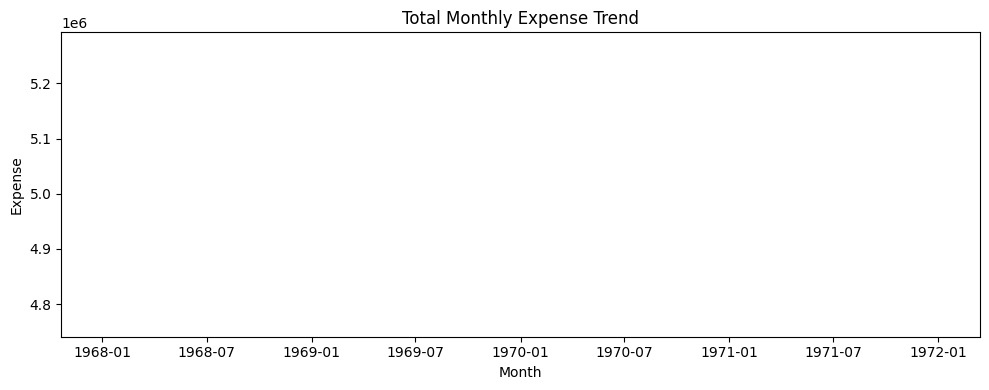

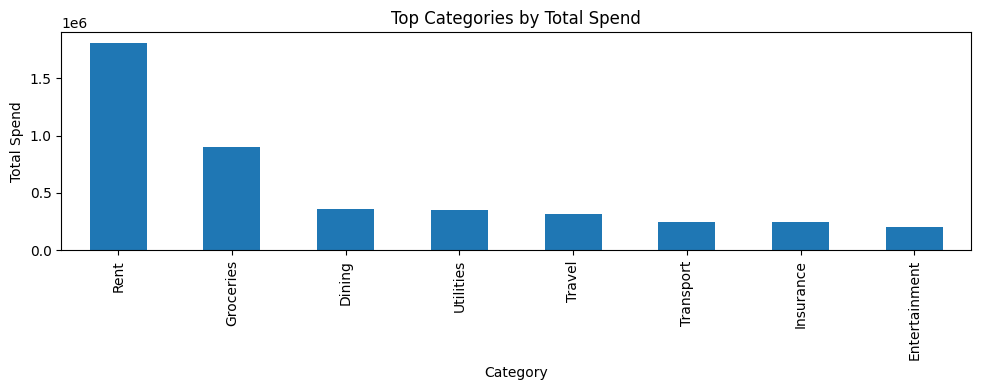

In [8]:

# EDA
#
print("\n--- EDA ---")
# Total expense trend
plt.figure(figsize= (10,4))
plt.plot(wide.index, wide["TOTAL_EXPENSE"])
plt.title("Total Monthly Expense Trend")
plt.xlabel("Month")
plt.ylabel("Expense")
plt.tight_layout()
plt.show()


# Total categories by spend
cat_totals = wide.drop(columns=["TOTAL_EXPENSE"]).sum().sort_values(ascending=False)
top_cats = cat_totals.head(TOP_CATEGORIES).index.tolist()

plt.figure(figsize=(10,4))
cat_totals.head(TOP_CATEGORIES).plot(kind="bar")
plt.title("Top Categories by Total Spend")
plt.xlabel("Category")
plt.ylabel("Total Spend")
plt.tight_layout()
plt.show()

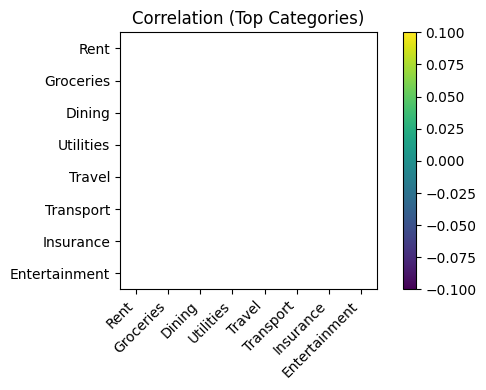

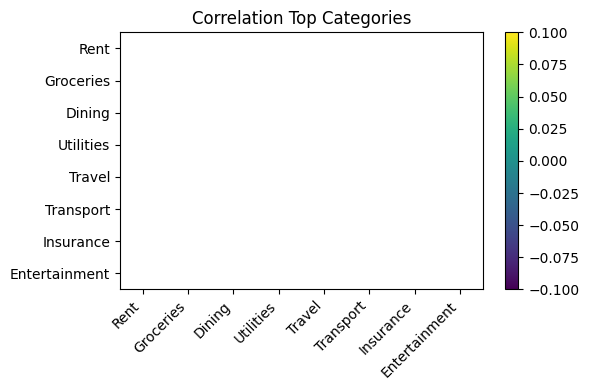

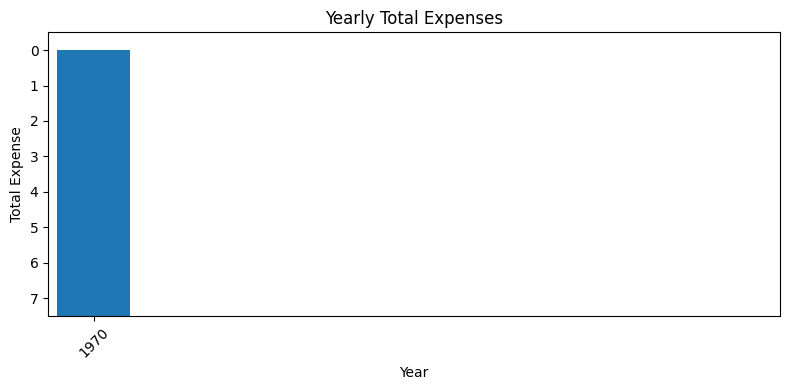

In [9]:
# Correlation across top categories

if len(top_cats) >= 2:
    corr = wide[top_cats].corr()
    plt.figure(figsize=(6,4))
    plt.imshow(corr.values)
    plt.title("Correlation (Top Categories)")
    plt.xticks (range (len(corr.columns)), corr.columns, rotation=45,
    ha="right")
    plt.yticks (range (len(corr.index)), corr.index)
    plt.colorbar ()
    plt.tight_layout()
    plt.show()


if len(top_cats) >= 2:
    corr = wide[top_cats].corr()

    plt.figure(figsize=(6,4))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation Top Categories")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Not enough categories for correlation plot")

# Yearly totals (TOTAL_EXPENSE)
# plt.figure(figsize=(8,4))
# plt.bar(yearly.index.astype(str), yearly ["TOTAL_EXPENSE"].values)
# plt.title("Yearly Total Expenses")
# plt.xlabel("Year")
# plt.ylabel("Total Expense")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(8,4))
plt.bar(yearly.index.astype(str), yearly["TOTAL_EXPENSE"].values)
plt.title("Yearly Total Expenses")
plt.xlabel("Year")
plt.ylabel("Total Expense")
plt.xticks(rotation=45)
plt.tight_layout()
plt.imshow(corr, vmin=-1, vmax=1, aspect="auto")

plt.show()


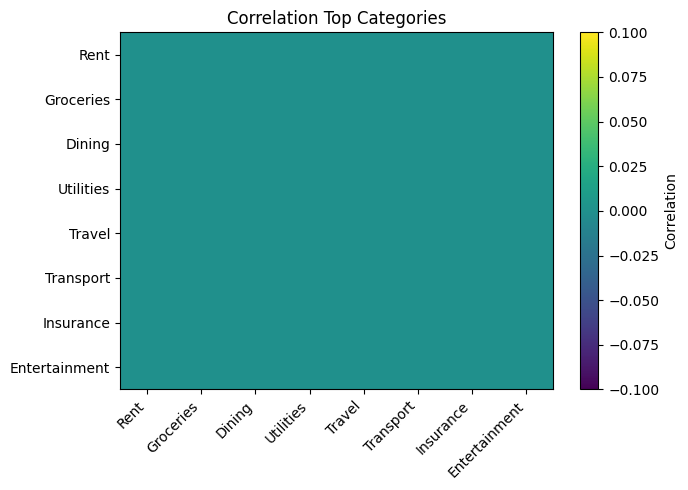

In [10]:
# Correlation across top categories
if len(top_cats) >= 2:
    corr = wide[top_cats].corr()

    # replace NaN correlations
    corr = corr.fillna(0)

    plt.figure(figsize=(7,5))
    plt.imshow(corr, aspect="auto")
    plt.title("Correlation Top Categories")

    plt.xticks(
        range(len(corr.columns)),
        corr.columns,
        rotation=45,
        ha="right"
    )
    plt.yticks(range(len(corr.index)), corr.index)

    plt.colorbar(label="Correlation")
    plt.tight_layout()
    plt.imshow(corr, vmin=-1, vmax=1, aspect="auto")

    plt.show()
else:
    print("Not enough categories for correlation plot")


In [1]:
print("\n--- Forecasting (TOTAL_EXPENSE) ---")


--- Forecasting (TOTAL_EXPENSE) ---
